In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

/Users/bryanwang/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
recidivism_data = pd.read_csv('NIJ_s_Recidivism_Challenge_Full_Dataset_20231120.csv', index_col = 'ID')

In [62]:
print(recidivism_data.shape)
display(recidivism_data.head())

(25835, 53)


,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,Prison_Offense,...,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3,Training_Sample
ID,,,,,,,,,,,,,,,,,,,,,
1,M,BLACK,43-47,16,False,3.0,Standard,At least some college,3 or more,Drug,...,0.000000,0.0,0.488562,0.447610,False,False,False,False,False,1
2,M,BLACK,33-37,16,False,6.0,Specialized,Less than HS diploma,1,Violent/Non-Sex,...,0.000000,0.0,0.425234,2.000000,False,True,False,False,True,1
3,M,BLACK,48 or older,24,False,7.0,High,At least some college,3 or more,Drug,...,0.166667,0.0,0.000000,0.000000,False,True,False,True,False,1
4,M,WHITE,38-42,16,False,7.0,High,Less than HS diploma,1,Property,...,0.000000,0.0,1.000000,0.718996,False,False,False,False,False,1
5,M,WHITE,33-37,16,False,4.0,Specialized,Less than HS diploma,3 or more,Violent/Non-Sex,...,0.058824,0.0,0.203562,0.929389,False,True,True,False,False,1


# Data Cleaning

In [3]:
# ---------- Rename ----------
# Rename Gender and Race to represent dummy variables
recidivism_data = recidivism_data.rename(columns={'Gender':'Male', 'Race':'White'})

# ---------- Convert Types ----------
# Convert type bool into np.bool_
recidivism_data['Gang_Affiliated'] = recidivism_data['Gang_Affiliated'].astype(np.bool_)

# ---------- One-hot encode nominal variables ----------
recidivism_data = pd.get_dummies(recidivism_data, columns = ['Prison_Offense']) 

# FOR NOW!!!!!!!!!!! Drop PUMA
recidivism_data = recidivism_data.drop(['Residence_PUMA'], axis=1)

In [4]:
# Print unqiue values of columns of string types for mapping
columns_rename = list(recidivism_data.select_dtypes(include='object'))

for feature in columns_rename:
    print(f"{feature}: " + str(recidivism_data[feature].unique()))

Male: ['M' 'F']
White: ['BLACK' 'WHITE']
Age_at_Release: ['43-47' '33-37' '48 or older' '38-42' '18-22' '23-27' '28-32']
Supervision_Level_First: ['Standard' 'Specialized' 'High' nan]
Education_Level: ['At least some college' 'Less than HS diploma' 'High School Diploma']
Dependents: ['3 or more' '1' '0' '2']
Prison_Years: ['More than 3 years' '1-2 years' 'Less than 1 year'
 'Greater than 2 to 3 years']
Prior_Arrest_Episodes_Felony: ['6' '7' '8' '4' '10 or more' '3' '9' '2' '5' '1' '0']
Prior_Arrest_Episodes_Misd: ['6 or more' '4' '0' '1' '3' '5' '2']
Prior_Arrest_Episodes_Violent: ['1' '3 or more' '0' '2']
Prior_Arrest_Episodes_Property: ['3' '0' '2' '5 or more' '1' '4']
Prior_Arrest_Episodes_Drug: ['3' '2' '1' '0' '5 or more' '4']
Prior_Arrest_Episodes_PPViolationCharges: ['4' '5 or more' '3' '0' '1' '2']
Prior_Conviction_Episodes_Felony: ['3 or more' '1' '2' '0']
Prior_Conviction_Episodes_Misd: ['3' '4 or more' '2' '0' '1']
Prior_Conviction_Episodes_Prop: ['2' '0' '1' '3 or more']
Pr

In [5]:
# Create a copy of the original dataset to preserve the original
recidivism = recidivism_data.copy()

# Create a dataframe for with the feature names and their respective mappings
feature_mapping = pd.DataFrame(columns=['feature_name', 'mapping'])
feature_mapping['feature_name'] = columns_rename

# ---------- CREATE MAPPINGS FOR EACH STRING COLUMN ----------

# Male
feature_mapping['mapping'][0] = {'M':1, 'F':0}
# White
feature_mapping['mapping'][1] = {'WHITE':1, 'BLACK':0}
# Age_at_Release
feature_mapping['mapping'][2] = {'18-22':1, '23-27':2, '28-32':3, '33-37':4,
                                 '38-42':5, '43-47':6,  '48 or older':7}
# Supervision_Level_First
feature_mapping['mapping'][3] = {'Standard':0, 'High':1, 'Specialized':2}
# Education_Level
feature_mapping['mapping'][4] = {'Less than HS diploma':0, 'High School Diploma':1, 
                                 'At least some college':2}
# Dependents
feature_mapping['mapping'][5] = {'0':0, '1':1, '2':2, '3 or more':3}
#Prison_Years
feature_mapping['mapping'][6] = {'Less than 1 year':0, '1-2 years':1, 'Greater than 2 to 3 years':2, 
                                 'More than 3 years':3}
#Prior_Arrest_Episodes_Felony
feature_mapping['mapping'][7] = {'1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9, '10 or more':10}
#Prior_Arrest_Episodes_Misd
feature_mapping['mapping'][8] = {'1':1, '2':2, '3':3, '4':4, '5':5, '6 or more':6}
#Prior_Arrest_Episodes_Violent
feature_mapping['mapping'][9] = {'0':0, '1':1, '2':2, '3 or more':3}
#Prior_Arrest_Episodes_Property
feature_mapping['mapping'][10] = {'0':0, '1':1, '2':2, '3':3, '4':4, '5 or more':5}
#Prior_Arrest_Episodes_Drug
feature_mapping['mapping'][11] = {'0':0, '1':1, '2':2, '3':3, '4':4, '5 or more':5}
#Prior_Arrest_Episodes_PPViolationCharges
feature_mapping['mapping'][12] = {'0':0, '1':1, '2':2, '3':3, '4':4, '5 or more':5}
#Prior_Conviction_Episodes_Felony
feature_mapping['mapping'][13] = {'0':0, '1':1, '2':2, '3 or more':3}
#Prior_Conviction_Episodes_Misd
feature_mapping['mapping'][14] = {'0':0, '1':1, '2':2, '3':3, '4':4, '5':5, '6 or more':6}
#Prior_Conviction_Episodes_Prop
feature_mapping['mapping'][15] = {'0':0, '1':1, '2':2, '3 or more':3}
#Prior_Conviction_Episodes_Drug
feature_mapping['mapping'][16] = {'0':0, '1':1, '2 or more':2}
#Delinquency_Reports
feature_mapping['mapping'][17] = {'0':0, '1':1, '2':2, '3':3, '4 or more':4}
#Program_Attendances
feature_mapping['mapping'][18] = {'1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9, '10 or more':10}
#Program_UnexcusedAbsences
feature_mapping['mapping'][19] = {'0':0, '1':1, '2':2, '3 or more':3}
#Residence_Changes
feature_mapping['mapping'][20] = {'0':0, '1':1, '2':2, '3 or more':3}

# Apply mapping
for (feature, mapping) in zip(feature_mapping['feature_name'], feature_mapping['mapping']):
    recidivism[feature] = recidivism[feature].map(mapping, na_action='ignore')
    
recidivism = recidivism.dropna()
    
display(recidivism)
print(recidivism.shape)

,Male,White,Age_at_Release,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,Prison_Years,Prior_Arrest_Episodes_Felony,...,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3,Training_Sample,Prison_Offense_Drug,Prison_Offense_Other,Prison_Offense_Property,Prison_Offense_Violent/Non-Sex,Prison_Offense_Violent/Sex
ID,,,,,,,,,,,,,,,,,,,,,
1,1,0,6,False,3.0,0.0,2,3,3,6.0,...,False,False,False,False,1,1,0,0,0,0
3,1,0,7,False,7.0,1.0,2,3,1,6.0,...,True,False,True,False,1,1,0,0,0,0
5,1,1,4,False,4.0,2.0,0,3,1,4.0,...,True,True,False,False,1,0,0,0,1,0
11,1,1,6,False,3.0,2.0,0,1,1,3.0,...,True,False,True,False,1,0,0,0,1,0
12,1,0,4,False,5.0,2.0,1,3,1,10.0,...,True,True,False,False,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26719,1,1,3,False,7.0,1.0,0,1,0,2.0,...,True,True,False,False,1,0,0,0,0,0
26727,1,1,5,False,4.0,0.0,0,1,0,1.0,...,True,False,True,False,1,0,0,0,0,0
26741,1,1,3,False,5.0,0.0,2,3,3,1.0,...,True,True,False,False,0,0,0,0,0,0


(6352, 56)


# EDA

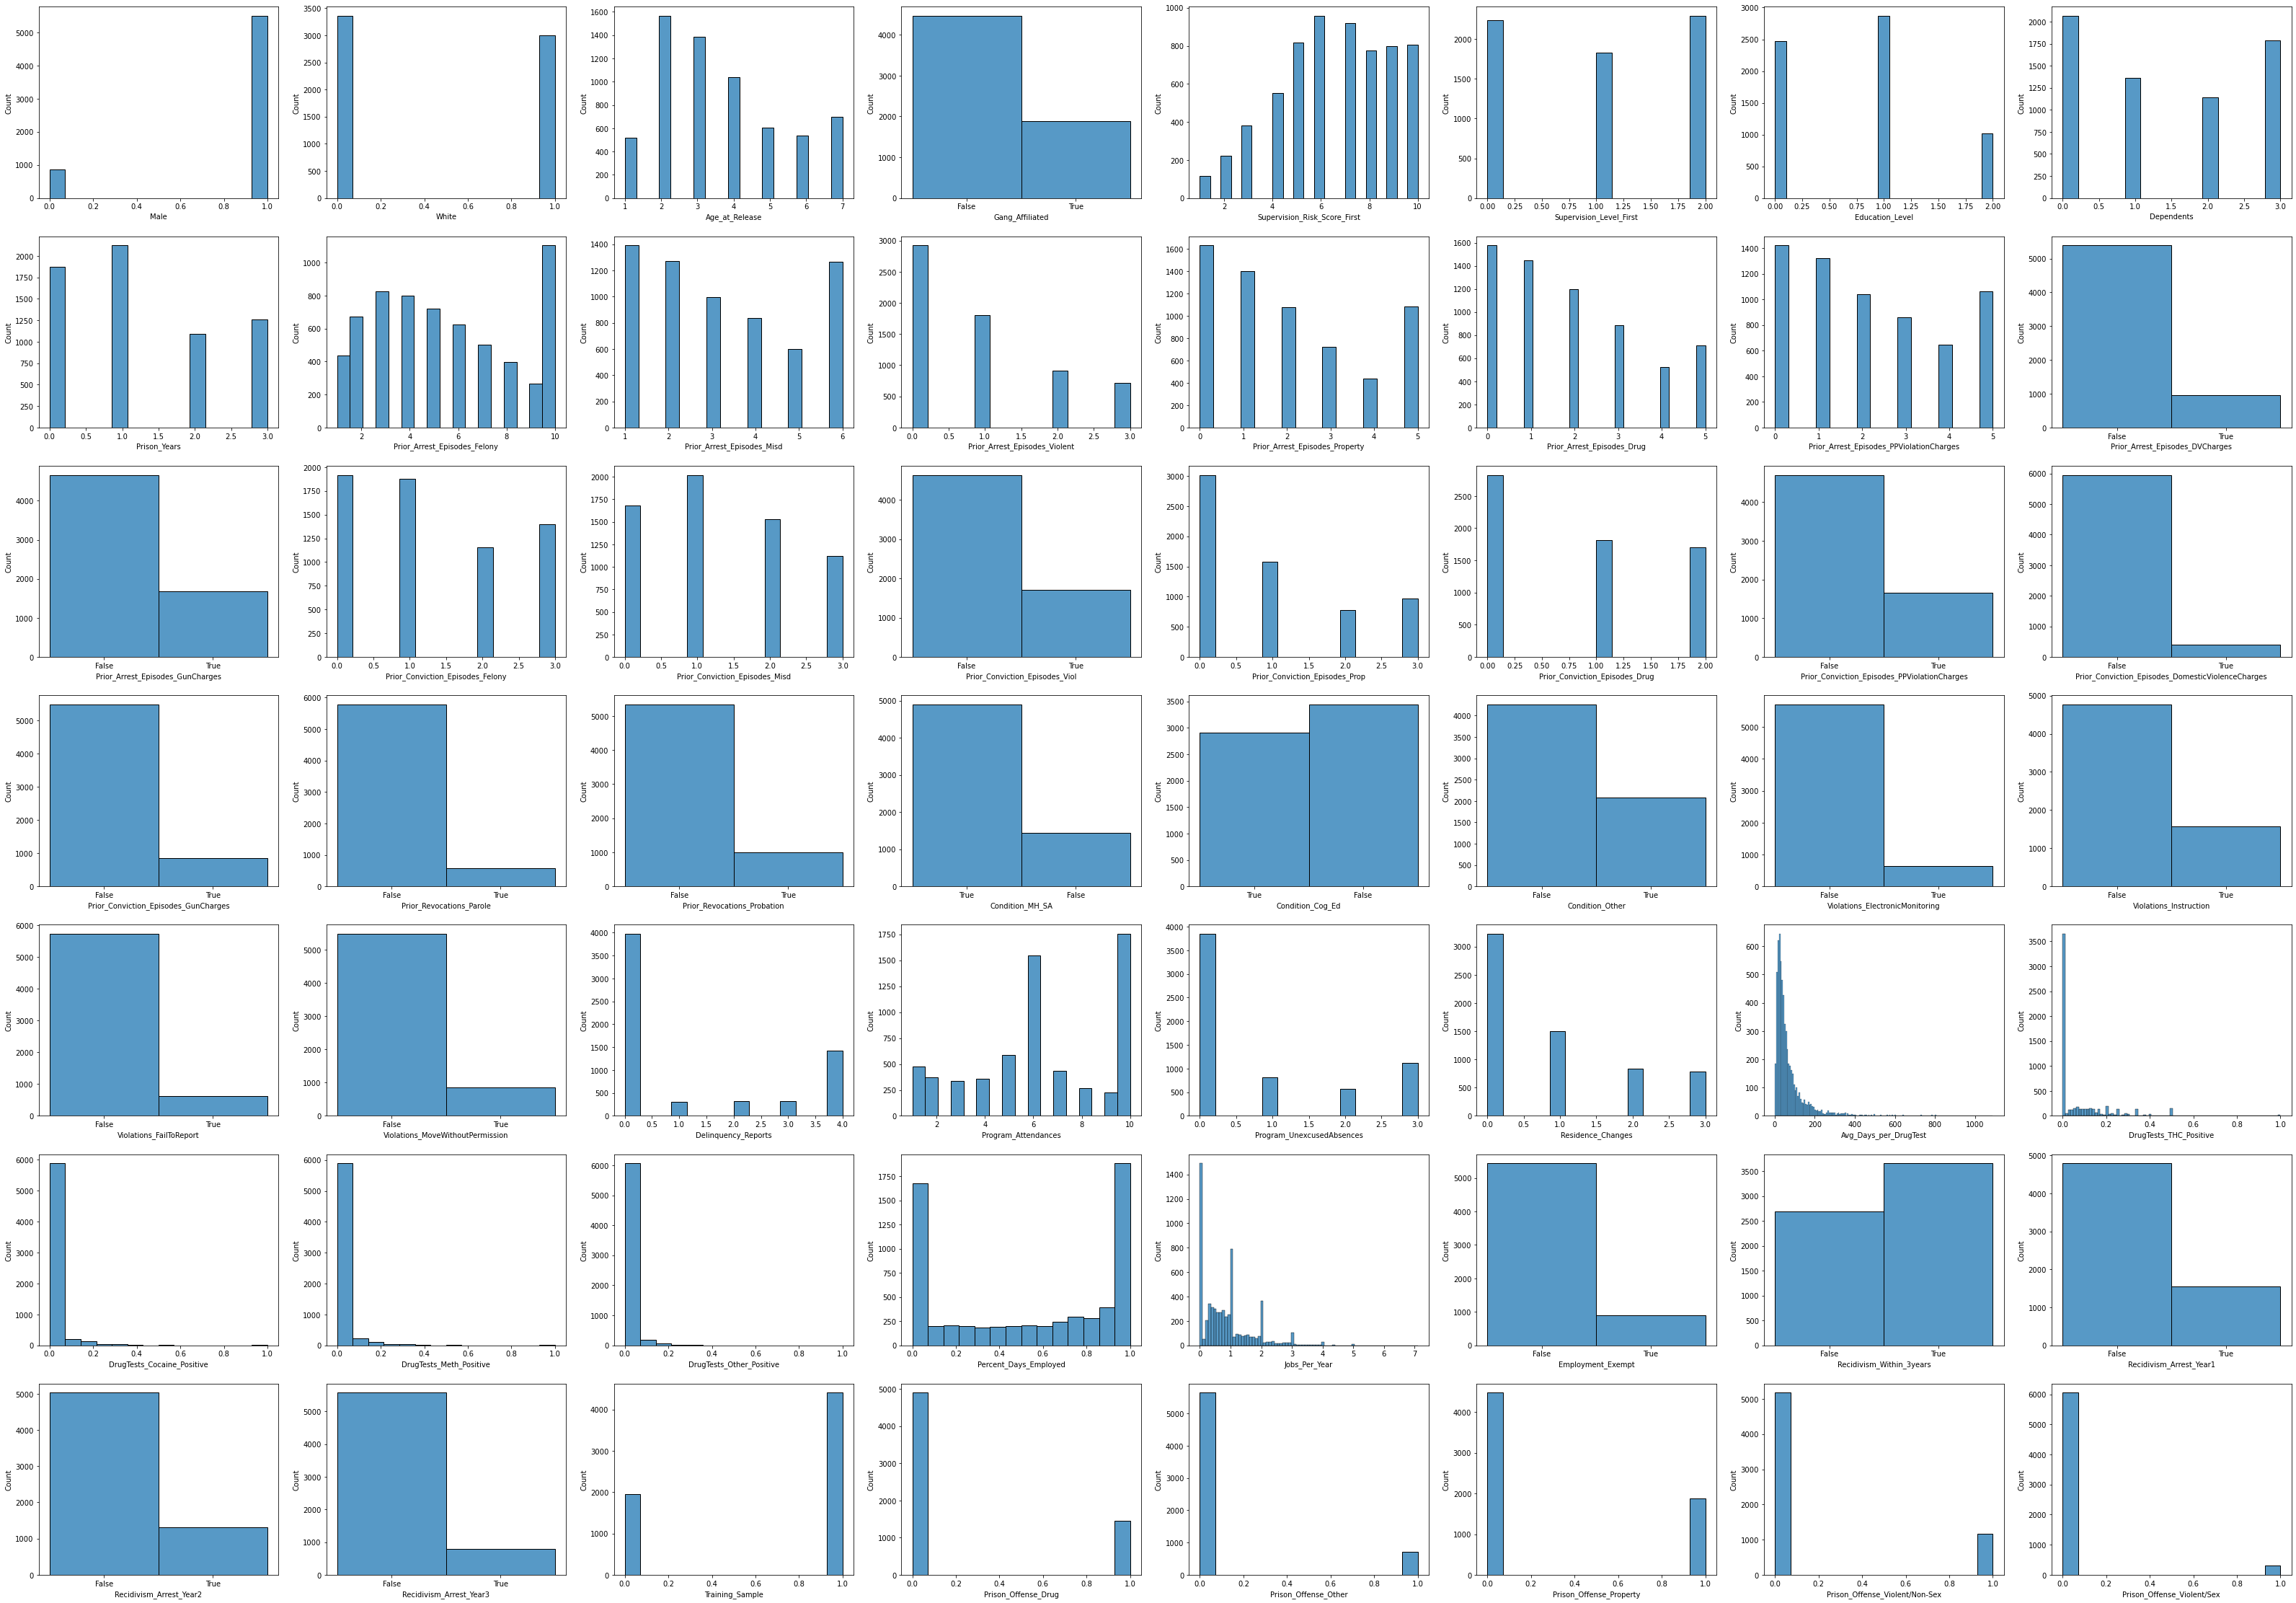

In [26]:
import math

# Histogram of each feature using only training data
num_features = len(recidivism.columns)
fig, axes = plt.subplots(7, math.ceil(num_features/7), figsize=(num_features, 40))

# flatten axes since it's 2D now: 6 x math.ceil(num_features/6)
for ax, (feat_name, feat) in zip(axes.flatten(), recidivism.items()):
    # sns.histplot doesn't work for booleans: converts 'True' and 'False' to their mathematical operators
    # convert booleans to strings (check if bool or no.bool_)
    if type(feat.iloc[0])==str:
        print(feat_name)
    
    if isinstance(feat.iloc[0], np.bool_):
        temp = feat.copy()
        sns.histplot(temp.astype(str), ax=ax)
    else:
        sns.histplot(feat, ax=ax)

In [6]:
recidivism['Recidivism_Within_3years'].value_counts()

True     3659
False    2693
Name: Recidivism_Within_3years, dtype: int64

In [10]:
# gender-dependents
gender_dependents = recidivism.groupby(['Male', 'Dependents']).mean()
gender_dependents = gender_dependents[['Recidivism_Within_3years', 'Recidivism_Arrest_Year1',
                                         'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3']]

print(gender_dependents)

                 Recidivism_Within_3years  Recidivism_Arrest_Year1  \
Male Dependents                                                      
0    0                           0.483193                 0.226891   
     1                           0.496774                 0.174194   
     2                           0.389189                 0.102703   
     3                           0.469314                 0.158845   
1    0                           0.589266                 0.256846   
     1                           0.637344                 0.282988   
     2                           0.614256                 0.259958   
     3                           0.552249                 0.233466   

                 Recidivism_Arrest_Year2  Recidivism_Arrest_Year3  
Male Dependents                                                    
0    0                          0.180672                 0.075630  
     1                          0.193548                 0.129032  
     2                     

# Modeling

In [7]:
# Define feature and target variables
X = recidivism.drop(columns=['Recidivism_Within_3years', 'Recidivism_Arrest_Year1',
                                         'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3'])
y = np.ravel(recidivism[['Recidivism_Within_3years']])

print(X.shape)
print(y.shape)

(6352, 52)
(6352,)


In [8]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4446, 52)
(1906, 52)
(4446,)
(1906,)


In [9]:
# Import packages
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [10]:
# Create accuracy metrics

# Specificity / Selectivity: True negative rate (TN / (TN + FP))
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

model_performances = pd.DataFrame(columns=['model', 'accuracy', 'specificity', 'AUC'])

## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
## ignore convergence warning from logistic regression & future warning from svm
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=FutureWarning)

**Basic Model Performance**

Accuracy(training): 0.7107512370670266
Accuracy(test): 0.7072402938090241
Specificity(training): 0.5940282870612886
Specificity(test): 0.5918367346938775


AUC score: 0.6898577612863327


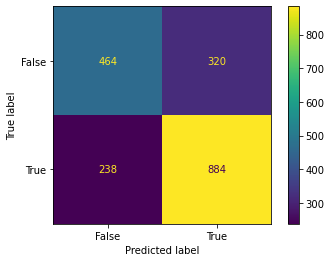

In [36]:
# Initialize the model
lgr = LogisticRegression(random_state=0)

# Build model
lgr.fit(X_train, y_train)
y_train_pred = lgr.predict(X_train)
y_test_pred = lgr.predict(X_test)

# Accuracy
print('Accuracy(training): ' + str(accuracy_score(y_train, y_train_pred)))
print('Accuracy(test): ' + str(accuracy_score(y_test, y_test_pred)))
# Specificity (True negative rate)
print('Specificity(training): ' + str(specificity_score(y_train, y_train_pred)))
print('Specificity(test): ' + str(specificity_score(y_test, y_test_pred)))
print('\n')
# AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred)
AUC_score = metrics.auc(fpr, tpr)
print('AUC score: ' + str(AUC_score))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=lgr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgr.classes_)
disp.plot()
plt.show()

**Fine-tuning**

In [112]:
from sklearn.model_selection import GridSearchCV

# Set up a grid of hyperparameter values to search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Initialize the model
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv = 10)
grid_search.fit(X_train, y_train)
best_C = grid_search.best_params_['C']

print(best_C)

1000


**Optimized Model Performance**

In [12]:
# Initialize the model
lgr = LogisticRegression(random_state=0, C=1)

# Build model
lgr.fit(X_train, y_train)
y_train_pred = lgr.predict(X_train)
y_test_pred = lgr.predict(X_test)

Accuracy(training): 0.7058029689608637
Accuracy(test): 0.7161594963273872
Specificity(training): 0.5892857142857143
Specificity(test): 0.6172370088719898


AUC score: 0.7016355142838016


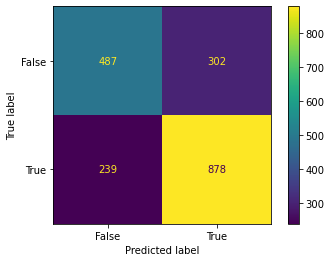

In [13]:
# Accuracy
print('Accuracy(training): ' + str(accuracy_score(y_train, y_train_pred)))
print('Accuracy(test): ' + str(accuracy_score(y_test, y_test_pred)))
accuracy_test = accuracy_score(y_test, y_test_pred)

# Specificity (True negative rate)
print('Specificity(training): ' + str(specificity_score(y_train, y_train_pred)))
print('Specificity(test): ' + str(specificity_score(y_test, y_test_pred)))
specificity_test = specificity_score(y_test, y_test_pred)
print('\n')

# AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred)
AUC_score = metrics.auc(fpr, tpr)
print('AUC score: ' + str(AUC_score))

# Update model performances dataframe
model_performance = pd.DataFrame({'model':['lgr'], 'accuracy':[accuracy_test], 
                                  'specificity':[specificity_test], 'AUC':[AUC_score]})
model_performances = model_performances.append(model_performance)

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=lgr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgr.classes_)
disp.plot()
plt.show()

## K-Nearest Neighbors

**Fine-tuning**

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_neighbors = range(1, 101)
# Create the random grid
random_grid = {'n_neighbors': n_neighbors}
display(random_grid)

# First create the base model to tune
knn = KNeighborsClassifier()
knn_random = RandomizedSearchCV(estimator = knn, param_distributions = random_grid, 
                               n_iter = 50, cv = 10, verbose=0, random_state=0, n_jobs = -1)
knn_random.fit(X_train, y_train)

{'n_neighbors': range(1, 101)}

/Users/bryanwang/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/bryanwang/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/bryanwang/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/bryanwang/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'n_neighbors': range(1, 101)},
                   random_state=0)

In [44]:
best_n_neighbors = knn_random.best_params_['n_neighbors']
print(f'best n_neighbors: {best_n_neighbors}')

best n_neighbors: 39


In [15]:
# Build model with optimal hyperparameters
knn = KNeighborsClassifier(n_neighbors = 39)

knn.fit(X_train, y_train)
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

Accuracy(training): 0.6619433198380567
Accuracy(test): 0.6385099685204617
Specificity(training): 0.4012605042016807
Specificity(test): 0.38910012674271227


AUC score: 0.6018911555826364


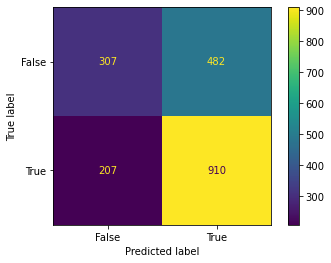

In [16]:
# Accuracy
print('Accuracy(training): ' + str(accuracy_score(y_train, y_train_pred)))
print('Accuracy(test): ' + str(accuracy_score(y_test, y_test_pred)))
accuracy_test = accuracy_score(y_test, y_test_pred)

# Specificity (True negative rate)
print('Specificity(training): ' + str(specificity_score(y_train, y_train_pred)))
print('Specificity(test): ' + str(specificity_score(y_test, y_test_pred)))
specificity_test = specificity_score(y_test, y_test_pred)
print('\n')

# AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred)
AUC_score = metrics.auc(fpr, tpr)
print('AUC score: ' + str(AUC_score))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.show()

# Update model performances dataframe
model_performance = pd.DataFrame({'model':['knn'], 'accuracy':[accuracy_test], 
                                  'specificity':[specificity_test], 'AUC':[AUC_score]})
model_performances = model_performances.append(model_performance)

## Decision Tree

**Basic Model Performance**

In [17]:
from sklearn.tree import DecisionTreeClassifier

# Build model with optimal hyperparameters
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_train_pred = dtc.predict(X_train)
y_test_pred = dtc.predict(X_test)

# Metrics: Accuracy and Specificity
# Accuracy
print('Accuracy(training): ' + str(accuracy_score(y_train, y_train_pred)))
print('Accuracy(test): ' + str(accuracy_score(y_test, y_test_pred)))
# Specificity (True negative rate)
print('Specificity(training): ' + str(specificity_score(y_train, y_train_pred)))
print('Specificity(test): ' + str(specificity_score(y_test, y_test_pred)))

Accuracy(training): 1.0
Accuracy(test): 0.6358866736621196
Specificity(training): 1.0
Specificity(test): 0.5944233206590621


**Fine-Tuning**

In [51]:
min_samples_leaf_values = [5, 10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
min_samples_split_values = [5, 10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
param_grid = {'min_samples_leaf': min_samples_leaf_values, 
              'min_samples_split': min_samples_split_values}

# 5-fold Cross Validation AND find best parameters to use
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_min_samples_split = grid_search.best_params_['min_samples_split']

In [52]:
print(f'best_min_samples_leaf: {best_min_samples_leaf}')
print(f'best_min_samples_split: {best_min_samples_split}')

best_min_samples_leaf: 20
best_min_samples_split: 300


**Optimized Model Performance**

In [18]:
# Build model with optimal hyperparameters
dtc = DecisionTreeClassifier(min_samples_split = 300, min_samples_leaf = 20)
dtc.fit(X_train, y_train)

y_train_pred = dtc.predict(X_train)
y_test_pred = dtc.predict(X_test)

Accuracy(training): 0.713225371120108
Accuracy(test): 0.7025183630640084
Specificity(training): 0.5194327731092437
Specificity(test): 0.5044359949302915


AUC score: 0.6734355444660409


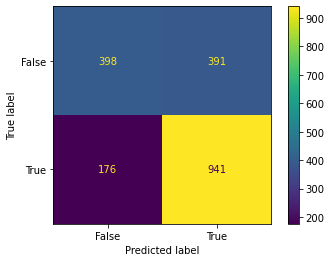

In [19]:
# Accuracy
print('Accuracy(training): ' + str(accuracy_score(y_train, y_train_pred)))
print('Accuracy(test): ' + str(accuracy_score(y_test, y_test_pred)))
accuracy_test = accuracy_score(y_test, y_test_pred)

# Specificity (True negative rate)
print('Specificity(training): ' + str(specificity_score(y_train, y_train_pred)))
print('Specificity(test): ' + str(specificity_score(y_test, y_test_pred)))
specificity_test = specificity_score(y_test, y_test_pred)
print('\n')

# AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred)
AUC_score = metrics.auc(fpr, tpr)
print('AUC score: ' + str(AUC_score))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred, labels=dtc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
disp.plot()
plt.show()

# Update model performances dataframe
model_performance = pd.DataFrame({'model':['dtc'], 'accuracy':[accuracy_test], 
                                  'specificity':[specificity_test], 'AUC':[AUC_score]})
model_performances = model_performances.append(model_performance)

## Random Forest

**Basic Model Performance**

In [20]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)

# Metrics: Accuracy and Specificity
# Accuracy
print('Accuracy(training): ' + str(accuracy_score(y_train, y_train_pred)))
print('Accuracy(test): ' + str(accuracy_score(y_test, y_test_pred)))
# Specificity (True negative rate)
print('Specificity(training): ' + str(specificity_score(y_train, y_train_pred)))
print('Specificity(test): ' + str(specificity_score(y_test, y_test_pred)))
print('\n')

#roc and auc
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred)
print('AUC score: ' + str(metrics.auc(fpr, tpr)))

Accuracy(training): 1.0
Accuracy(test): 0.727177334732424
Specificity(training): 1.0
Specificity(test): 0.6096324461343473


AUC score: 0.709919177409161


**Fine-Tuning**

In [57]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

display(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

In [58]:
# Use the random grid to search for best hyperparameters. THIS TAKES A LONG TIME TO TRAIN!!

# First create the base model to tune
rfc = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, 
                               n_iter = 40, cv = 5, verbose=0, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

/Users/bryanwang/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/bryanwang/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/bryanwang/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/bryanwang/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=40,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500]},
                   random_state=42)

In [59]:
print('n_estimators: ' + str(rf_random.best_params_['n_estimators']))
print('max_depth: ' + str(rf_random.best_params_['max_depth']))

n_estimators: 200
max_depth: 60


**Optimized Model Performance**

In [21]:
# Build model with optimal hyperparameters
rfc = RandomForestClassifier(n_estimators = 200, max_depth=60)

rfc.fit(X_train, y_train)
y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)

Accuracy(training): 1.0
Accuracy(test): 0.7256033578174187
Specificity(training): 1.0
Specificity(test): 0.6070975918884665


AUC score: 0.7082041227123622


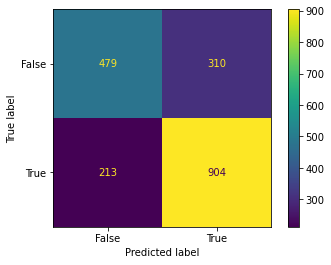

In [22]:
# Accuracy
print('Accuracy(training): ' + str(accuracy_score(y_train, y_train_pred)))
print('Accuracy(test): ' + str(accuracy_score(y_test, y_test_pred)))
accuracy_test = accuracy_score(y_test, y_test_pred)

# Specificity (True negative rate)
print('Specificity(training): ' + str(specificity_score(y_train, y_train_pred)))
print('Specificity(test): ' + str(specificity_score(y_test, y_test_pred)))
specificity_test = specificity_score(y_test, y_test_pred)
print('\n')

# AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred)
AUC_score = metrics.auc(fpr, tpr)
print('AUC score: ' + str(AUC_score))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp.plot()
plt.show()

# Update model performances dataframe
model_performance = pd.DataFrame({'model':['rfc'], 'accuracy':[accuracy_test], 
                                  'specificity':[specificity_test], 'AUC':[AUC_score]})
model_performances = model_performances.append(model_performance)

## Neural Networks

In [1]:
## Import Keras and Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-12-09 14:32:56.752516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/bryanwang/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Preprocessing**

In [2]:
# Convert data types for training neural network
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

NameError: name 'X_train' is not defined

In [27]:
# Reserve 30% of training samples for validation
val = math.ceil(0.3 * 4446)

X_val = X_train[-val:]
y_val = y_train[-val:]
X_train_nn = X_train[:-val]
y_train_nn = y_train[:-val]

**Fine-Tuning**

In [29]:
## Defines the Neural Network model
inputs = keras.Input(shape=(52,))
x = layers.Dense(32, activation="relu")(inputs)
x = layers.Dense(16, activation="relu")(inputs)
outputs = layers.Dense(units=1, activation="sigmoid")(x)

nn = keras.Model(inputs=inputs, outputs=outputs)

In [30]:
## Prepare the model with additional information about how to train it
nn.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer Adam
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy()],
)

## Fit our model with the initial training data, and check it with the "validation" training data!
print("Fit model on training data")
history = nn.fit(
    X_train_nn,
    y_train_nn,
    batch_size=64,
    epochs=20,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, y_val)
)

Fit model on training data
Epoch 1/20
49/49 [==============================] - 1s 6ms/step - loss: 1.6270 - binary_accuracy: 0.5386 - val_loss: 0.8952 - val_binary_accuracy: 0.5750
Epoch 2/20
49/49 [==============================] - 0s 4ms/step - loss: 0.7534 - binary_accuracy: 0.5970 - val_loss: 0.7040 - val_binary_accuracy: 0.5945
Epoch 3/20
49/49 [==============================] - 0s 4ms/step - loss: 0.6825 - binary_accuracy: 0.6099 - val_loss: 0.6725 - val_binary_accuracy: 0.6177
Epoch 4/20
49/49 [==============================] - 0s 3ms/step - loss: 0.6640 - binary_accuracy: 0.6256 - val_loss: 0.6567 - val_binary_accuracy: 0.6312
Epoch 5/20
49/49 [==============================] - 0s 2ms/step - loss: 0.6509 - binary_accuracy: 0.6346 - val_loss: 0.6456 - val_binary_accuracy: 0.6379
Epoch 6/20
49/49 [==============================] - 0s 2ms/step - loss: 0.6444 - binary_accuracy: 0.6430 - val_loss: 0.6370 - val_binary_accuracy: 0.6432
Epoch 7/20
49/49 [==============================]

In [31]:
y_train_pred = nn.predict(X_train_nn, verbose=0)
y_test_pred = nn.predict(X_test, verbose=0)
# Accuracy
results = nn.evaluate(X_train_nn, y_train_nn, batch_size=128, verbose=0)
print('Accuracy(train):', results[1])
results = nn.evaluate(X_test, y_test, batch_size=128, verbose=0)
print('Accuracy(test):', results[1])

Accuracy(train): 0.6828406453132629
Accuracy(test): 0.6799580454826355


In [32]:
# Convert from probabilities to binary labels

# Since we are trying to reasonably minimize false positives (maximize specificity) we raise the treshold
threshold = 0.60
y_train_pred = (y_train_pred >= threshold).astype("float32")
y_test_pred = (y_test_pred >= threshold).astype("float32")

**Optimized Model Performance**

Accuracy(training): 0.6854113110539846
Accuracy(test): 0.6657922350472193
Specificity(training): 0.6119402985074627
Specificity(test): 0.6096324461343473


AUC score: 0.6575467512677107


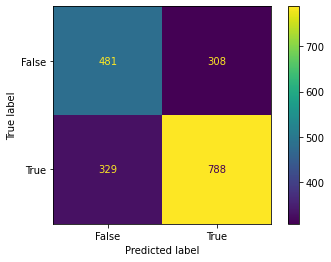

In [33]:
# Accuracy
print('Accuracy(training): ' + str(accuracy_score(y_train_nn, y_train_pred)))
print('Accuracy(test): ' + str(accuracy_score(y_test, y_test_pred)))
accuracy_test = accuracy_score(y_test, y_test_pred)

# Specificity (True negative rate)
print('Specificity(training): ' + str(specificity_score(y_train_nn, y_train_pred)))
print('Specificity(test): ' + str(specificity_score(y_test, y_test_pred)))
specificity_test = specificity_score(y_test, y_test_pred)
print('\n')

# AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred)
AUC_score = metrics.auc(fpr, tpr)
print('AUC score: ' + str(AUC_score))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp.plot()
plt.show()

# Update model performances dataframe
model_performance = pd.DataFrame({'model':['nn'], 'accuracy':[accuracy_test], 
                                  'specificity':[specificity_test], 'AUC':[AUC_score]})
model_performances = model_performances.append(model_performance)

In [34]:
display(model_performances)

,model,accuracy,specificity,AUC
0,lgr,0.716159,0.617237,0.701636
0,knn,0.638510,0.389100,0.601891
0,dtc,0.702518,0.504436,0.673436
0,rfc,0.725603,0.607098,0.708204
0,nn,0.665792,0.609632,0.657547


From out results, we see that the neural network performs reasonably well in regards to accuracy (0.6741) and the best in regards to specificity (0.746988). We also notice that the logistic regression model and random forest trees model outperform the neural network in accuracy (0.6962 and 0.7051, respectively) although have much lower specificity scores (0.5638 and 0.5481, respectively). Given these results, we include these three models in our ensemble modeling.

# Ensembling

In [35]:
# lgr
lgr = LogisticRegression(random_state=0, C=1)
lgr_pred = lgr.fit(X_train, y_train).predict(X_test)

# dtc
dtc = DecisionTreeClassifier(min_samples_split = 300, min_samples_leaf = 20)
dtc_pred = dtc.fit(X_train, y_train).predict(X_test)

# rfc
rfc = RandomForestClassifier(random_state=0, n_estimators = 300, max_depth=70)
rfc_pred = rfc.fit(X_train, y_train).predict(X_test)

In [36]:
# nn
# Preprocessing
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

## Defines the Neural Network model
inputs = keras.Input(shape=(52,))
x = layers.Dense(32, activation="relu")(inputs)
x = layers.Dense(16, activation="relu")(inputs)
outputs = layers.Dense(units=1, activation="sigmoid")(x)
nn = keras.Model(inputs=inputs, outputs=outputs)

## Prepare the model with additional information about how to train it
nn.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer Adam
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy()],
)

## Fit our model with the initial training data, and check it with the "validation" training data!
history = nn.fit(
    X_train, #don't need a validation set here since we already did our fine-tuning
    y_train,
    batch_size=64,
    epochs=20,
    verbose=0
)

threshold = 0.60
nn_pred = nn.predict(X_test, verbose=0).flatten()
nn_pred = (nn_pred >= threshold).astype("float32")

In [37]:
# These predictions are all predictions for the training data
print('lgr accuracy: ' + str(accuracy_score(y_test, lgr_pred)))
print('dtc accuracy: ' + str(accuracy_score(y_test, dtc_pred)))
print('rfc accuracy: ' + str(accuracy_score(y_test, rfc_pred)))
print('nn accuracy: ' + str(accuracy_score(y_test, nn_pred)))

lgr accuracy: 0.7145855194123819
dtc accuracy: 0.7025183630640084
rfc accuracy: 0.727177334732424
nn accuracy: 0.6773347324239245


**Create stacking dataset**

In [38]:
stacking_dataset = {'lgr': lgr_pred, 'dtc':dtc_pred, 'rfc':rfc_pred, 'nn':nn_pred}
stacking_df = pd.DataFrame(stacking_dataset)

In [39]:
print(stacking_df.shape) # These are predictions for the y_test values (X_test)
display(stacking_df)

(1906, 4)


,lgr,dtc,rfc,nn
0,1.0,1.0,1.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0
...,...,...,...,...
1901,0.0,0.0,0.0,0.0
1902,0.0,0.0,0.0,0.0
1903,0.0,1.0,0.0,0.0
1904,0.0,1.0,0.0,0.0


## Majority vote

In [41]:
vote = pd.DataFrame(stacking_df.sum(axis=1))

def convert_to_binary(value):
    return 1 if value >= 3 else 0

# Apply the function to each element in the DataFrame
vote = vote.applymap(convert_to_binary)   

Accuracy: 0.7130115424973767
Specificity: 0.6856780735107731


AUC score: 0.7089983921716803


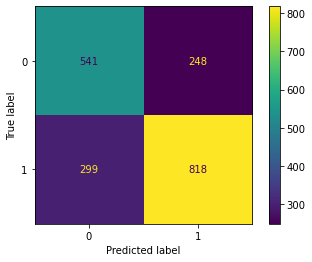

In [42]:
# Accuracy
accuracy = accuracy_score(y_test, vote)
print(f"Accuracy: {accuracy}")

# Specificity (True negative rate)
print('Specificity: ' + str(specificity_score(y_test, vote)))
print('\n')

# AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, vote)
AUC_score = metrics.auc(fpr, tpr)
print('AUC score: ' + str(AUC_score))

# Confusion matrix
cm = confusion_matrix(y_test, vote, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

## Logistic Regression

In [43]:
# Create train-test split
X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble = train_test_split(stacking_df, y_test, test_size=0.3)

print(X_train_ensemble.shape)
print(X_test_ensemble.shape)
print(y_train_ensemble.shape)
print(y_test_ensemble.shape)

(1334, 4)
(572, 4)
(1334,)
(572,)


In [44]:
# Set up a grid of hyperparameter values to search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Initialize the model
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv = 15)
grid_search.fit(X_train_ensemble, y_train_ensemble)
best_C = grid_search.best_params_['C']

print(best_C)

NameError: name 'GridSearchCV' is not defined

**Build Model**

In [45]:
# Define a Meta-Model
meta_model = LogisticRegression(C=0.1)

# Train the Meta-Model
meta_model.fit(X_train_ensemble, y_train_ensemble)

# Make Predictions with the Stacked Model
y_train_pred = meta_model.predict(X_train_ensemble)
y_test_pred = meta_model.predict(X_test_ensemble)

**Optimized Model Performance**

Stacked Model Accuracy (training): 0.7293853073463268
Stacked Model Accuracy (testing): 0.7185314685314685
Specificity(training): 0.5875912408759124
Specificity(test): 0.5809128630705395


AUC score: 0.6998219904476564


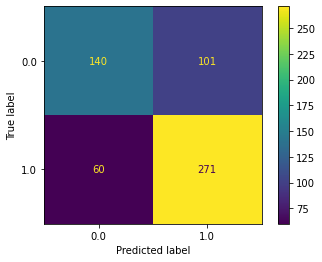

In [46]:
# Accuracy
accuracy_train = accuracy_score(y_train_ensemble, y_train_pred)
print(f"Stacked Model Accuracy (training): {accuracy_train}")
accuracy_test = accuracy_score(y_test_ensemble, y_test_pred)
print(f"Stacked Model Accuracy (testing): {accuracy_test}")

# Specificity
print('Specificity(training): ' + str(specificity_score(y_train_ensemble, y_train_pred)))
print('Specificity(test): ' + str(specificity_score(y_test_ensemble, y_test_pred)))
print('\n')

# AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test_ensemble, y_test_pred)
AUC_score = metrics.auc(fpr, tpr)
print('AUC score: ' + str(AUC_score))

# Confusion matrix
cm = confusion_matrix(y_test_ensemble, y_test_pred, labels=meta_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=meta_model.classes_)
disp.plot()
plt.show()

## Feature importance

LogisticRegression(C=1, random_state=0)
Percent_Days_Employed 0.089 +/- 0.005
Age_at_Release 0.040 +/- 0.006
Jobs_Per_Year 0.021 +/- 0.003
Male     0.013 +/- 0.002
Prior_Arrest_Episodes_Felony 0.011 +/- 0.003


KNeighborsClassifier(n_neighbors=39)
Avg_Days_per_DrugTest 0.033 +/- 0.005
Supervision_Risk_Score_First 0.030 +/- 0.004
Age_at_Release 0.024 +/- 0.004
Prior_Arrest_Episodes_Felony 0.010 +/- 0.003
Prior_Arrest_Episodes_PPViolationCharges 0.009 +/- 0.003


DecisionTreeClassifier(min_samples_leaf=20, min_samples_split=300)
Percent_Days_Employed 0.140 +/- 0.006
Jobs_Per_Year 0.048 +/- 0.005
DrugTests_THC_Positive 0.026 +/- 0.003
Supervision_Risk_Score_First 0.025 +/- 0.003
Prior_Conviction_Episodes_Misd 0.010 +/- 0.002


RandomForestClassifier(max_depth=70, n_estimators=300, random_state=0)
Percent_Days_Employed 0.136 +/- 0.004
Jobs_Per_Year 0.021 +/- 0.002
Supervision_Risk_Score_First 0.017 +/- 0.001
Age_at_Release 0.015 +/- 0.001
DrugTests_THC_Positive 0.013 +/- 0.001




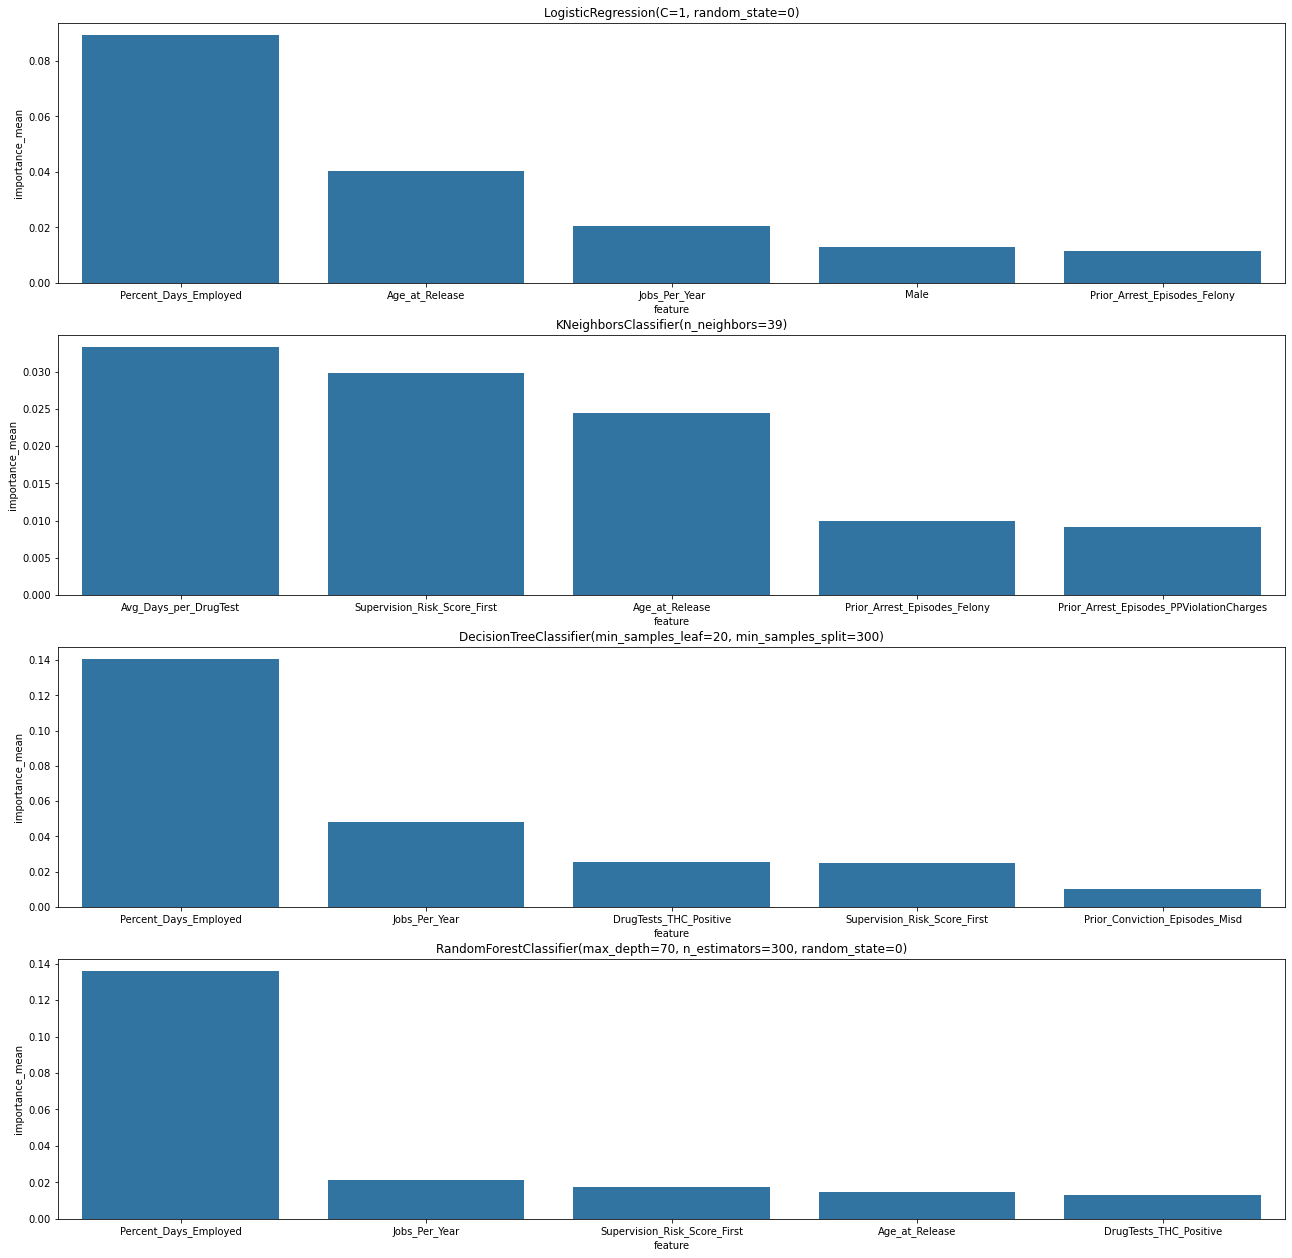

In [61]:
from sklearn.inspection import permutation_importance

models = [lgr, knn, dtc, rfc]
fig, axes = plt.subplots(4, 1, figsize=(22, 22))

for ax, model in zip(axes.flatten(), models): 
    print(model)
    r = permutation_importance(model, X_train, y_train, n_repeats=30, random_state=0)
    
    barplot_data = pd.DataFrame(columns=['feature', 'importance_mean'])

    for i in r.importances_mean.argsort()[::-1]:
        
        # look only at the top 5 most important features
        if len(barplot_data) >= 5:
            continue
            
        # threshold for importance
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            temp = pd.DataFrame({'feature':[X_train.columns.values[i]], 
                                 'importance_mean':[r.importances_mean[i]]})
            barplot_data = pd.concat([barplot_data, temp], ignore_index=True)
            
            print(f"{X_train.columns.values[i]:<8}"
                  f" {r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")
            
    sns.barplot(barplot_data, x='feature', y='importance_mean', ax=ax)
    ax.set_title(model)
    
    print('\n')


### Recidivism vs. Features

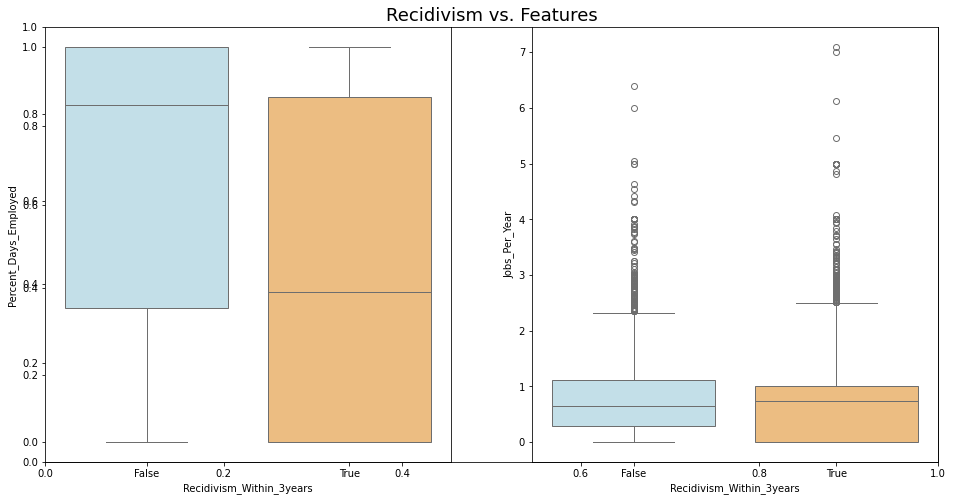

In [64]:
feature_list = ['Percent_Days_Employed', 'Jobs_Per_Year']

fig = plt.figure(figsize=(16,8)) 

# Add a title to the plot
plt.title('Recidivism vs. Features', fontsize=18)  

for i in range(len(feature_list)):
    sub = fig.add_subplot(1, 2, i+1)
    sns.boxplot(recidivism, x='Recidivism_Within_3years', y=feature_list[i], palette = 'RdYlBu_r')

### Percent Days Employed

/var/folders/6t/m8p7kvf97cd38j154jl_hcx00000gn/T/ipykernel_24896/3957950740.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recidivism_employment['Percent_Days_Employed'] = recidivism_employment['Percent_Days_Employed'].apply(percentage_category)


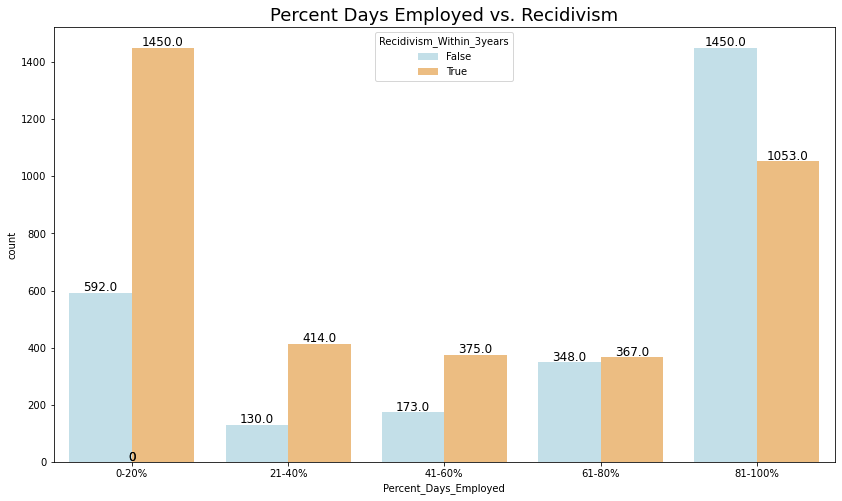

In [62]:
# Create a separate dataset
recidivism_employment = recidivism[['Percent_Days_Employed', 'Recidivism_Within_3years']]

# Define a function to map percentages to categories
def percentage_category(percentage):
    if percentage <= .20:
        return '0-20%'
    elif percentage <= .40:
        return '21-40%'
    elif percentage <= .60:
        return '41-60%'
    elif percentage <= .80:
        return '61-80%'
    else:
        return '81-100%'

# Apply the label_category function to create a new column 'Category'
recidivism_employment['Percent_Days_Employed'] = recidivism_employment['Percent_Days_Employed'].apply(percentage_category)

order = ['0-20%', '21-40%', '41-60%', '61-80%', '81-100%']

fig = plt.figure(figsize=(14,8))
ax = sns.countplot(data = recidivism_employment, x="Percent_Days_Employed", 
                   hue="Recidivism_Within_3years", order=order, palette='RdYlBu_r')

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Add a title to the plot
plt.title('Percent Days Employed vs. Recidivism', fontsize=18)    

plt.show()


### Age at Release

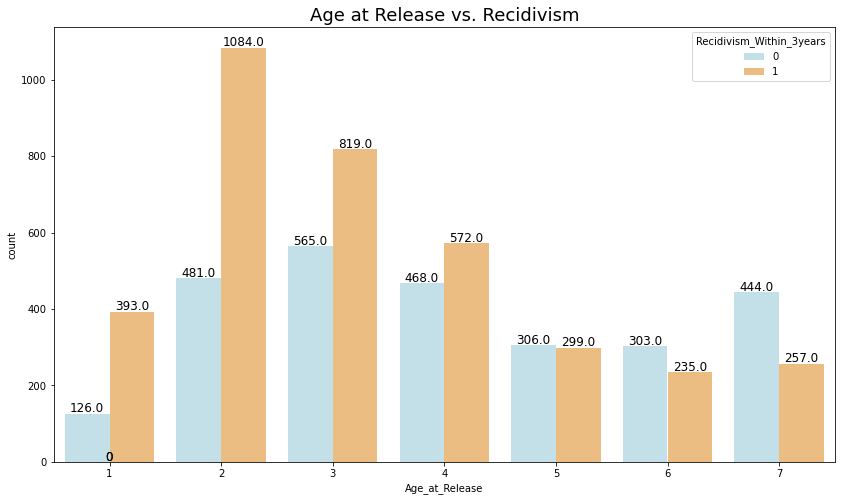

In [128]:
recidivism['Recidivism_Within_3years'] = recidivism['Recidivism_Within_3years'].astype("int64")

fig = plt.figure(figsize=(14,8))
ax = sns.countplot(data = recidivism, x="Age_at_Release", hue="Recidivism_Within_3years", palette = 'RdYlBu_r')

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')
    
# Add a title to the plot
plt.title('Age at Release vs. Recidivism', fontsize=18)

plt.show()

### Jobs Per Year vs. Recidivism

/var/folders/6t/m8p7kvf97cd38j154jl_hcx00000gn/T/ipykernel_94400/3739907825.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recidivism_jobs['Jobs_Per_Year'] = recidivism_jobs['Jobs_Per_Year'].apply(jobs_category)


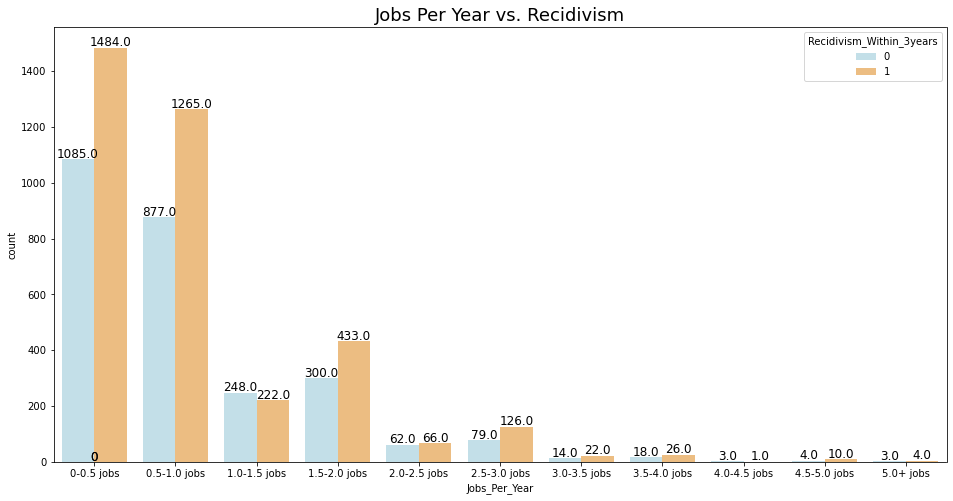

In [129]:
# Define a function to map percentages to categories
def jobs_category(percentage):
    if percentage <= 0.5:
        return '0-0.5 jobs'
    elif percentage <= 1:
        return '0.5-1.0 jobs'
    elif percentage <= 1.5:
        return '1.0-1.5 jobs'
    elif percentage <= 2.0:
        return '1.5-2.0 jobs'
    elif percentage <= 2.5:
        return '2.0-2.5 jobs'
    elif percentage <= 3.0:
        return '2.5-3.0 jobs'
    elif percentage <= 3.5:
        return '3.0-3.5 jobs'
    elif percentage <= 4.0:
        return '3.5-4.0 jobs'
    elif percentage <= 4.5:
        return '4.0-4.5 jobs'
    elif percentage <= 5.0:
        return '4.5-5.0 jobs'
    else:
        return '5.0+ jobs'
    
order = ['0-0.5 jobs', '0.5-1.0 jobs', '1.0-1.5 jobs', '1.5-2.0 jobs', '2.0-2.5 jobs', '2.5-3.0 jobs', 
         '3.0-3.5 jobs', '3.5-4.0 jobs', '4.0-4.5 jobs', '4.5-5.0 jobs', '5.0+ jobs']

recidivism_jobs = recidivism[['Jobs_Per_Year', 'Recidivism_Within_3years']]

# Apply the label_category function to create a new column 'Category'
recidivism_jobs['Jobs_Per_Year'] = recidivism_jobs['Jobs_Per_Year'].apply(jobs_category)

fig = plt.figure(figsize=(16,8))
ax = sns.countplot(data = recidivism_jobs, x="Jobs_Per_Year", hue="Recidivism_Within_3years", 
                   order=order, palette = 'RdYlBu_r')
# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Add a title to the plot
plt.title('Jobs Per Year vs. Recidivism', fontsize=18)

plt.show()